In [6]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from collections import OrderedDict

from torchvision import datasets
from torchvision.models import MobileNet_V3_Small_Weights

from torchvision.transforms import ToTensor
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import transforms, models, datasets
from torchvision.io import read_image
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os

class SpeakerIdentificationImageDataset(Dataset):
    def __init__(self, root, transform=None, target_transform=None):
        classes = pd.read_csv(root + os.sep + "classes.csv")
        annotations_file = root + os.sep + "annotations.csv"
        self.img_labels = pd.read_csv(annotations_file)
        self.root = root
        self.transform = transform
        self.target_transform = target_transform
        self.classes = [row["Name"] for index, row in classes.iterrows()]
        self.class_to_idx = {
            row["Name"]: row["Label"] for index, row in classes.iterrows()
        }

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.root, self.img_labels.iloc[idx, 0])
        image = read_image(img_path)
        label = self.img_labels.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

def count_number_of_parameters(model):
    return sum(p.numel() for p in model.parameters())


In [7]:
DATA_DIR = "/Users/akashganesan/Downloads/16000_pcm_speeches"
IMAGE_SIZE = 64

data_transforms = transforms.Compose(
    [
        transforms.Resize((IMAGE_SIZE, IMAGE_SIZE), antialias=True),
        transforms.ConvertImageDtype(torch.float),
    ]
)

dataset = SpeakerIdentificationImageDataset(DATA_DIR, transform=data_transforms)

train_size = int(0.9 * len(dataset))
test_size = len(dataset) - train_size
training_data, test_data = torch.utils.data.random_split(
    dataset, [train_size, test_size]
)

Shape of X [N, C, H, W]: torch.Size([1, 3, 64, 64])
Shape of y: torch.Size([1]) torch.int64

X:  tensor([[[[1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          ...,
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.]],

         [[1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          ...,
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.]],

         [[1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          ...,
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.]]]])
y:  tensor([0])
Scalar y:  0
label:  Jens_Stoltenberg


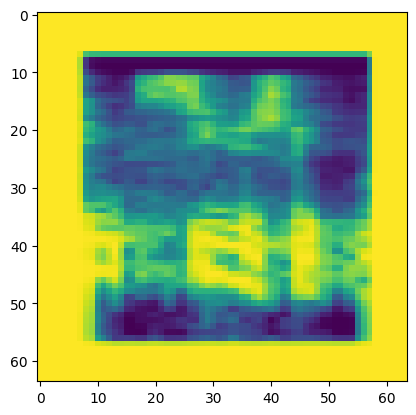

In [8]:
batch_size = 1

# Create data loaders.
test_dataloader = DataLoader(test_data, batch_size=batch_size)

for X, y in test_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}\n")
    print("X: ", X)
    print("y: ", y)
    print("Scalar y: ", y[0].item())
    break
    
label = dataset.classes[y[0].item()]
print("label: ", label)
imgplot = plt.imshow(X[0][0])

In [9]:
# Get cpu, gpu or mps device for training.

device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)

print(f"Using {device} device")


Using cpu device


In [22]:
FINE_TUNE = False

if not FINE_TUNE:
    for param in mobilenet.parameters():  # Freeze parameters so we don't update them
        param.requires_grad = False

mobilenet = models.mobilenet_v3_small(weights=MobileNet_V3_Small_Weights.IMAGENET1K_V1)

new_layers = nn.Sequential(OrderedDict([
    ('new1', nn.Linear(576, 500)),
    ('relu', nn.ReLU()),
    ('new2', nn.Linear(500, 5))
]))
mobilenet.classifier = new_layers



In [23]:
mobilenet.to(device)
model = mobilenet
batch_size = 1
test_dataloader = DataLoader(test_data, batch_size=batch_size)

X, y = next(iter(test_dataloader))

X = X.to(device)
print(X.shape)
pred = model(X)

pred.shape

torch.Size([1, 3, 64, 64])


torch.Size([1, 5])

In [24]:
def train(dataloader, model, loss_fn, optimizer):
    losses, accuracies = [], []
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        optimizer.zero_grad()
        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        # Nudge
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
            accuracy = (
                torch.sum((torch.argmax(pred, dim=1) == y).type(torch.float)) / len(y)
            ).item()
            losses.append(loss)
            accuracies.append(accuracy)
    return losses, accuracies


def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(
        f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n"
    )

In [25]:

batch_size = 16

model = mobilenet

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# Create data loaders.
train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

epochs = 5
train_losses, train_accuracies = [], []
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    losses, accuracies = train(train_dataloader, model, loss_fn, optimizer)
    train_losses.extend(losses)
    train_accuracies.extend(accuracies)
    test(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 1.668337  [   16/ 6750]
loss: 0.177045  [ 1616/ 6750]
loss: 0.184028  [ 3216/ 6750]
loss: 0.244282  [ 4816/ 6750]
loss: 0.324745  [ 6416/ 6750]
Test Error: 
 Accuracy: 94.7%, Avg loss: 0.195595 

Epoch 2
-------------------------------
loss: 0.149088  [   16/ 6750]
loss: 0.008522  [ 1616/ 6750]
loss: 0.107054  [ 3216/ 6750]
loss: 0.052583  [ 4816/ 6750]
loss: 0.012523  [ 6416/ 6750]
Test Error: 
 Accuracy: 97.1%, Avg loss: 0.077903 

Epoch 3
-------------------------------
loss: 0.078362  [   16/ 6750]
loss: 0.003099  [ 1616/ 6750]
loss: 0.008364  [ 3216/ 6750]
loss: 0.030489  [ 4816/ 6750]
loss: 0.328387  [ 6416/ 6750]
Test Error: 
 Accuracy: 95.6%, Avg loss: 0.131187 

Epoch 4
-------------------------------
loss: 0.064154  [   16/ 6750]
loss: 0.002594  [ 1616/ 6750]
loss: 0.031639  [ 3216/ 6750]
loss: 0.016830  [ 4816/ 6750]
loss: 0.006787  [ 6416/ 6750]
Test Error: 
 Accuracy: 97.6%, Avg loss: 0.080843 

Epoch 5
------------------------

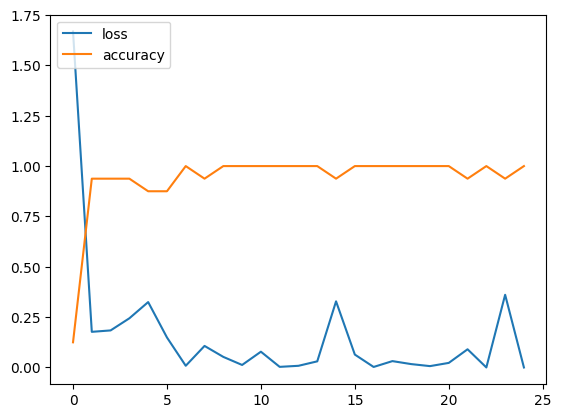

In [26]:
plt.plot(train_losses, label = "loss")
plt.plot(train_accuracies, label = "accuracy")
plt.legend(loc="upper left")

plt.show()

In [27]:
count_number_of_parameters(model)

1218013